In [1]:
import os.path as path
import raw_data_preprocessing as rdp
import warnings
import regressor as reg
import cluster as clu
import intervention_data_preprocessing as idp
import individual_differences_plot as plot
warnings.filterwarnings('ignore')

googledrive_loc = '/datasets/yis-google-drive'
data_folder_loc = 'Yi_UCI_research/GSR other works/2020 Summer_predict individual training/data/'
file_name = 'raw data/combined_3datasets.csv'
data_path = path.join(googledrive_loc, data_folder_loc, file_name)
raw_data = rdp.read_raw_data(data_path)
print('Used Feature columns: {}'.format(rdp.feature_col_names))
data_nomissing_training = rdp.delete_missing_row(raw_data)
# rdp.demographic_info(data_nomissing_training)
descpriptive_result = rdp.descriptive_info(data_nomissing_training)

Used Feature columns: ['MR_accpre', 'WM_Zpre', 'IC_Zreverse_pre', 'NT_Zpre', 'TCA_Zscore', 'CFQMALscore', 'Avg_grit_amb', 'NEOFFIExtraversion', 'NEOFFIAgreeableness', 'NEOFFIConscientiousness', 'NEOFFIEmotionalstability', 'NEOFFIIntellectorOpenness', 'VGQHoursCategorySumPastYear_Z', 'ParentalEducationSum', 'SelfReportedSESRatingSum', 'Physicalhealth', 'Physicalfitness', 'Psychohealth', 'Gamified', 'Difficulty', 'Bilingual']
The sample size of raw data is 949.
The sample size of no missing data (listwise) is 568.
Categorical Gamified information:Gamified
Gamified       315
Nongamified    253
dtype: int64
Categorical Difficulty information:Difficulty
Difficult     50
Middle       181
Moderate     169
hard         150
dtype: int64
Categorical Bilingual information:Bilingual
Bilingual      403
Monolingual    103
dtype: int64


In [2]:
# clean intervention data (delete outliers)
int_test = idp.InterventionProcessor(data_nomissing_training)
int_test.basic_analyze()
int_test.mark_outlier_stewd(['std','mean'])
int_test.delete_outlier()

The average maximun span across sessions is 5.157 with sd 5.815
The average standard deviation across sessions is 0.874 with sd 1.782
The average span across sessions is 3.920 with sd 3.733
The skew of std is 7.766
std:MC=0.193
interval of std is 2.6941854040225532 to -0.15348068866153236
     Unique  mean_1  mean_2  mean_3  mean_4  mean_5  mean_6  mean_7  mean_8  \
33       34   4.140   6.510   9.100   7.920   9.050   9.130   8.830  13.560   
41       42   4.150   7.010  18.550  29.390  38.250  43.580  49.000  51.500   
44       45   2.530   2.420   2.770   3.070   2.550   2.780   2.740   3.550   
147     148   2.510   3.010   3.520   3.960   5.700   7.230   8.600  10.450   
472     473   3.000   3.000   4.000   4.000   6.000   7.000   9.000  10.000   
505     506   4.000   7.000   9.000   8.000   9.000   9.000   9.000  14.000   
582     583   3.000   2.000   3.000   3.000   3.000   3.000   3.000   4.000   
583     584   4.000   7.000  19.000  29.000  38.000  44.000  49.000  52.000   

In [3]:
#using regressor to fit individual training data
piece_lin_reg = reg.PiecewiselinRegressor(['knot', 'slope1', 'slope2','turning_value'])
log_lin_reg = reg.LogRegressor(['log_slope', 'log_bias'])
lin_reg = reg.LinearRegressor(['linear_slope', 'linear_bias'])

# ['knot','slope1','slope2','std','max','r2','turning_value']
# ['linear_slope', 'linear_bias']
int_test.register_regressor(piece_lin_reg)
int_test.fit()
# plot.plot_distribution(int_test.data, ['knot','slope1','slope2','std','max','r2'])

The average r2 for <class 'regressor.PiecewiselinRegressor'> is: 0.728
The num of objects can not fit by pwlf: Unique            0
mean_1            0
mean_2            0
mean_3            0
mean_4            0
mean_5            0
mean_6            0
mean_7            0
mean_8            0
mean_9            0
mean_10           0
max               0
std               0
mean              0
outlier           0
knot             42
slope1           42
slope2           42
turning_value    42
r2               42
dtype: int64
The sample size that can fit with pwlf: 506


The silhouette score of AgglomerativeClustering(n_clusters=4) is: 0.402
The Davies-Bouldin score of AgglomerativeClustering(n_clusters=4) is: 0.622
Sample of each cluster: hierar_4
0    261
1    164
2     78
3      3
dtype: int64
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


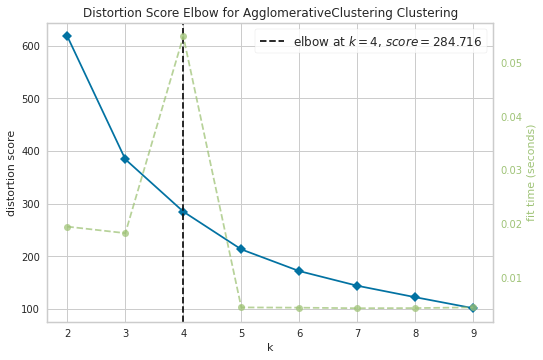

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


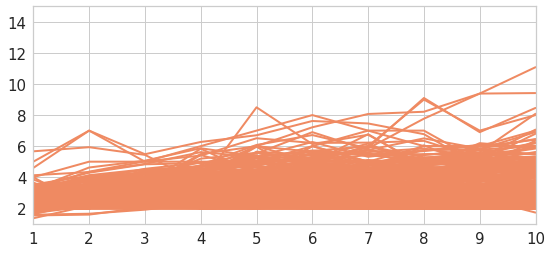

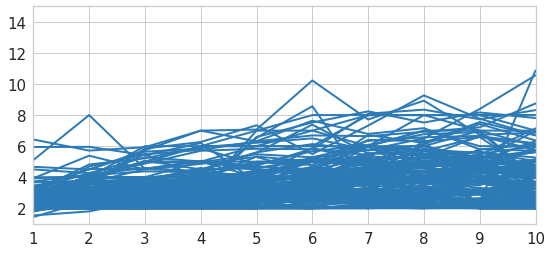

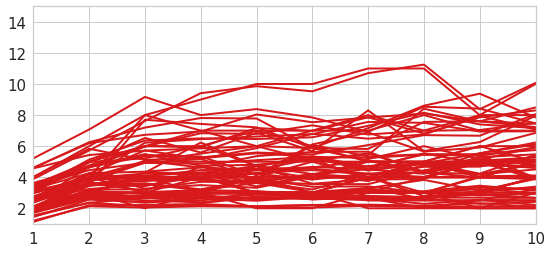

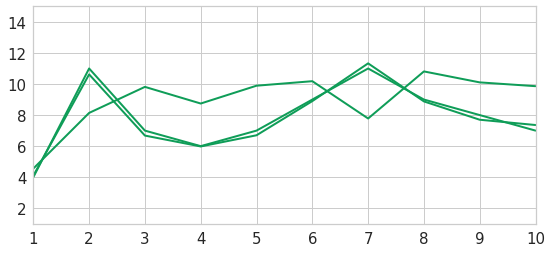

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


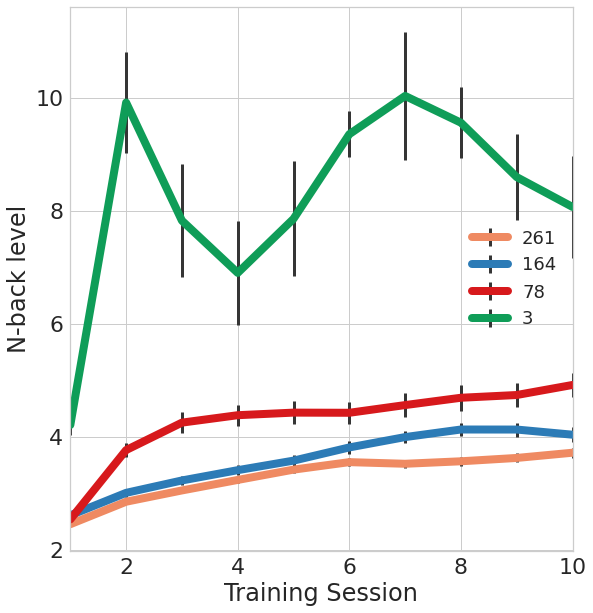

In [4]:
# clustering features
std_max = ['max','std'] 
pwlf = ['knot','slope1'] # 'turning_value'
all_sess = ['mean_' + str(i) for i in range(1,11)]


# clustering methods
kmeans_3com = clu.Kmeans(3, pwlf)
hac_3com = clu.Hierarchical(4, pwlf)
em_3com = clu.EM(3, pwlf)
dbc = clu.DensityBased(3, pwlf)
# register clustering method
int_test.register_cluster_model(hac_3com)
int_test.cluster()
# plot
plot.plot_cluster_result(int_test.data, int_test.intervention_col_names, int_test.clustering_model.cluster_name)
# plot.bar_plot_cluster(int_test.data, ['knot','slope1'], int_test.clustering_model.cluster_name)
# plot.plot_scatter_cluster(int_test.data, ['knot','slope1'], int_test.clustering_model.cluster_name)

In [5]:
int_test.data

,Unique,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,...,max,std,mean,outlier,knot,slope1,slope2,turning_value,r2,hierar_4
0,1,2.640,2.810,2.730,2.420,2.390,4.060,3.270,3.570,3.540,...,4.060,0.578697,3.1030,False,4.0,0.000106,0.186261,2.420,0.540017,0
1,2,3.440,4.760,6.000,5.930,7.170,6.970,7.860,6.810,7.860,...,8.300,1.515483,6.5100,False,3.0,1.302000,0.303786,6.000,0.932745,2
2,3,3.660,2.150,2.220,2.000,2.000,2.100,2.340,2.290,2.240,...,3.660,0.482748,2.3270,False,2.0,-1.578444,0.024333,2.150,0.958252,0
4,5,3.010,3.830,4.540,4.930,5.080,5.110,5.420,5.480,5.510,...,5.510,0.810603,4.8110,False,4.0,0.659638,0.061568,4.930,0.968347,0
6,7,2.060,2.160,2.150,2.280,2.220,2.160,2.110,2.390,2.060,...,2.390,0.103193,2.1840,False,4.0,0.050702,-0.005818,2.280,0.217962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,932,2.542,3.111,2.500,2.440,2.450,2.476,2.824,2.105,3.045,...,3.273,0.368999,2.6766,False,8.0,-0.047302,0.477692,2.105,0.566162,1
932,933,5.105,8.000,4.533,5.056,4.600,5.125,4.900,4.333,4.682,...,8.000,1.041695,5.1484,False,8.0,-0.235858,0.370246,4.333,0.258210,1
934,935,4.500,4.261,4.955,4.957,5.476,5.286,3.208,5.095,4.885,...,5.654,0.704961,4.8277,False,7.0,-0.041672,0.325564,3.208,0.188224,1
936,937,3.038,2.552,3.773,3.800,2.818,2.529,3.111,2.111,2.375,...,10.875,2.582606,3.6982,False,9.0,-0.109500,8.412222,2.375,0.965352,1


In [6]:
# Assign labels to clusters
naming_dict = {0:'short_benefit', 1:'long_benefit', 2:'much_benefit'}
int_test.create_labels(dict_naming=naming_dict, cluster_col='hierar_4', delete1cluster=True, cluster_delete=3)

## Feature preprocessing

In [7]:
# Feature preprocessing
import feature_preprocessor as fp
fp_test = fp.FeatureProcessor(data_nomissing_training,add_demographic=True)
fp_test.delete_missing_rows(8)
fp_test.make_dummy()
fp_test.features_impute_missing()


#fp_test.corr_features()
#fp_test.distri_features()
#fp_test.discretize_features()

Original length of data is : 568
Delete rows have >= crtieria missing values in features
The data length now is :527
Feature MR_accpre missing counts: 1(0.2 %)
Feature WM_Zpre missing counts: 2(0.4 %)
Feature IC_Zreverse_pre missing counts: 1(0.2 %)
Feature NT_Zpre missing counts: 2(0.4 %)
Feature TCA_Zscore missing counts: 0(0.0 %)
Feature CFQMALscore missing counts: 0(0.0 %)
Feature Avg_grit_amb missing counts: 0(0.0 %)
Feature NEOFFIExtraversion missing counts: 0(0.0 %)
Feature NEOFFIAgreeableness missing counts: 0(0.0 %)
Feature NEOFFIConscientiousness missing counts: 0(0.0 %)
Feature NEOFFIEmotionalstability missing counts: 0(0.0 %)
Feature NEOFFIIntellectorOpenness missing counts: 0(0.0 %)
Feature VGQHoursCategorySumPastYear_Z missing counts: 2(0.4 %)
Feature ParentalEducationSum missing counts: 27(5.1 %)
Feature SelfReportedSESRatingSum missing counts: 0(0.0 %)
Feature Physicalhealth missing counts: 45(8.5 %)
Feature Physicalfitness missing counts: 45(8.5 %)
Feature Psychohealth

In [8]:
fp_test.data

,Unique,MR_accpre,WM_Zpre,IC_Zreverse_pre,NT_Zpre,TCA_Zscore,CFQMALscore,Avg_grit_amb,NEOFFIExtraversion,NEOFFIAgreeableness,...,"Ethnicity_Native Hawaiian or Other Pacific Islander,Asian","Ethnicity_Native Hawaiian or Other Pacific Islander,Asian,White",Ethnicity_Other or Don't Want to Specify,Ethnicity_Other or Dont Want to Specify,Ethnicity_White,"Ethnicity_White,Other or Don't Want to Specify","Ethnicity_White,Other or Dont Want to Specify",HispanicLatino_I D,HispanicLatino_No,HispanicLatino_Yes
0,1,0.348,0.210380,-2.517163,0.080728,15.00,17.0,4.2750,4.125,4.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.652,0.568729,0.542494,0.308363,20.00,34.0,3.1750,1.875,3.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0.565,-1.807106,-0.236908,0.581092,24.00,23.0,4.1375,3.000,4.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.565,-0.047331,1.309682,-0.522600,17.00,21.0,3.4125,3.250,3.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,7,0.739,-0.047331,0.219768,0.107500,26.00,24.0,3.8500,2.500,4.375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,944,0.738,0.311018,-0.668042,0.371453,8.00,22.0,3.0625,4.500,3.000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
944,945,0.786,-0.776262,-0.289754,-0.859937,23.00,17.0,4.1250,4.000,4.125,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
945,946,0.571,-0.619189,-2.670383,-1.073131,26.00,32.0,3.5875,3.125,4.250,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
946,947,0.690,0.983513,0.390509,0.534357,1.42,24.0,4.1875,3.375,3.750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
int_test.data

,Unique,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,...,max,std,mean,outlier,knot,slope1,slope2,turning_value,r2,hierar_4
0,1,2.640,2.810,2.730,2.420,2.390,4.060,3.270,3.570,3.540,...,4.060,0.578697,3.1030,False,4.0,0.000106,0.186261,2.420,0.540017,short_benefit
1,2,3.440,4.760,6.000,5.930,7.170,6.970,7.860,6.810,7.860,...,8.300,1.515483,6.5100,False,3.0,1.302000,0.303786,6.000,0.932745,much_benefit
2,3,3.660,2.150,2.220,2.000,2.000,2.100,2.340,2.290,2.240,...,3.660,0.482748,2.3270,False,2.0,-1.578444,0.024333,2.150,0.958252,short_benefit
4,5,3.010,3.830,4.540,4.930,5.080,5.110,5.420,5.480,5.510,...,5.510,0.810603,4.8110,False,4.0,0.659638,0.061568,4.930,0.968347,short_benefit
6,7,2.060,2.160,2.150,2.280,2.220,2.160,2.110,2.390,2.060,...,2.390,0.103193,2.1840,False,4.0,0.050702,-0.005818,2.280,0.217962,short_benefit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,932,2.542,3.111,2.500,2.440,2.450,2.476,2.824,2.105,3.045,...,3.273,0.368999,2.6766,False,8.0,-0.047302,0.477692,2.105,0.566162,long_benefit
932,933,5.105,8.000,4.533,5.056,4.600,5.125,4.900,4.333,4.682,...,8.000,1.041695,5.1484,False,8.0,-0.235858,0.370246,4.333,0.258210,long_benefit
934,935,4.500,4.261,4.955,4.957,5.476,5.286,3.208,5.095,4.885,...,5.654,0.704961,4.8277,False,7.0,-0.041672,0.325564,3.208,0.188224,long_benefit
936,937,3.038,2.552,3.773,3.800,2.818,2.529,3.111,2.111,2.375,...,10.875,2.582606,3.6982,False,9.0,-0.109500,8.412222,2.375,0.965352,long_benefit


## Classification preprocessing

In [10]:
import classification_preprocessor as cp
cp_test = cp.ClassifyPreprocessor(int_test.data, fp_test.data, label_name='hierar_4')
# cp_test.delete_outlier() 
# cp_test.feature_test()
# cp_test.feature_selection(10)
# cp_test.use_categorical_features()

In [11]:
cp_test.data

,MR_accpre,WM_Zpre,IC_Zreverse_pre,NT_Zpre,TCA_Zscore,CFQMALscore,Avg_grit_amb,NEOFFIExtraversion,NEOFFIAgreeableness,NEOFFIConscientiousness,...,"Ethnicity_Native Hawaiian or Other Pacific Islander,Asian,White",Ethnicity_Other or Don't Want to Specify,Ethnicity_Other or Dont Want to Specify,Ethnicity_White,"Ethnicity_White,Other or Don't Want to Specify","Ethnicity_White,Other or Dont Want to Specify",HispanicLatino_I D,HispanicLatino_No,HispanicLatino_Yes,hierar_4
Unique,,,,,,,,,,,,,,,,,,,,,
1,0.348,0.210380,-2.517163,0.080728,15.000,17.0,4.2750,4.125,4.625,4.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,short_benefit
2,0.652,0.568729,0.542494,0.308363,20.000,34.0,3.1750,1.875,3.375,3.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,much_benefit
3,0.565,-1.807106,-0.236908,0.581092,24.000,23.0,4.1375,3.000,4.875,4.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,short_benefit
5,0.565,-0.047331,1.309682,-0.522600,17.000,21.0,3.4125,3.250,3.625,4.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,short_benefit
7,0.739,-0.047331,0.219768,0.107500,26.000,24.0,3.8500,2.500,4.375,3.250,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,short_benefit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,0.786,0.468091,-1.030518,1.693579,-0.665,35.0,3.6125,4.125,4.625,2.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,long_benefit
931,0.952,0.053307,-0.085044,0.010611,19.000,20.0,3.2375,3.375,4.125,3.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,long_benefit
932,0.500,-0.204404,-0.142153,-1.535980,13.000,28.0,2.2500,1.500,3.750,3.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,long_benefit


In [12]:
#cp_test.data.to_csv(path.join(googledrive_loc, data_folder_loc, 'predictors_label_2022.csv'))

In [13]:
#split training and test sets
X_train, X_test, y_train, y_test = cp_test.train_test_split()

The shape of training set before resample: (372, 51) and (372,)
The sample weight before resample: Counter({'short_benefit': 193, 'long_benefit': 122, 'much_benefit': 57})
The shape of test set: (93, 51) and (93,)


In [14]:
resample_dict = {'short_benefit':193, 'long_benefit':193, 'much_benefit':193}
x_train_new, y_train_new, orig_len, feature_names = cp_test.resample_standardize(X_train, y_train, resample_dict, oversample=True)
print('The input and output shape: {} and {}'.format(x_train_new.shape, y_train_new.shape))
print(orig_len)
print(feature_names)

The sample weight after resample: Counter({'short_benefit': 193, 'much_benefit': 193, 'long_benefit': 193})
The input and output shape: (579, 51) and (579,)
372
['MR_accpre', 'WM_Zpre', 'IC_Zreverse_pre', 'NT_Zpre', 'TCA_Zscore', 'CFQMALscore', 'Avg_grit_amb', 'NEOFFIExtraversion', 'NEOFFIAgreeableness', 'NEOFFIConscientiousness', 'NEOFFIEmotionalstability', 'NEOFFIIntellectorOpenness', 'VGQHoursCategorySumPastYear_Z', 'ParentalEducationSum', 'SelfReportedSESRatingSum', 'Physicalhealth', 'Physicalfitness', 'Psychohealth', 'Gamified_Gamified', 'Gamified_Nongamified', 'Difficulty_Difficult', 'Difficulty_Middle', 'Difficulty_Moderate', 'Difficulty_hard', 'Bilingual_Bilingual', 'Bilingual_Monolingual', 'Gender_Female', 'Gender_Male', "Gender_Other or Don't Want to Specify", 'Ethnicity_American Indian/Alaska Native', 'Ethnicity_American Indian/Alaska Native,Native Hawaiian or Other Pacific Islander', 'Ethnicity_American Indian/Alaska Native,White', 'Ethnicity_Asian', 'Ethnicity_Asian,Black 

In [17]:
saved_data_path = path.join(googledrive_loc, data_folder_loc, 'saved data/2022/April/')
cp_test.save_data(X_train, X_test, y_train, y_test, orig_len, feature_names, saved_data_path)

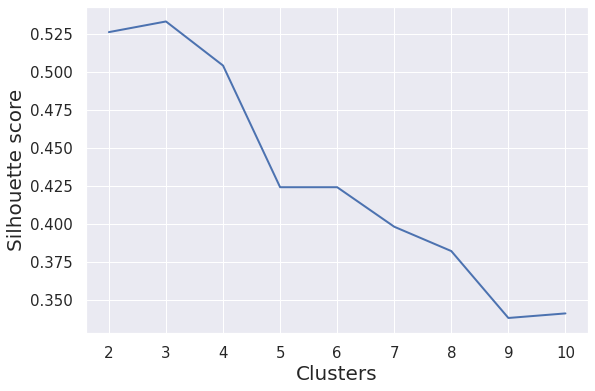

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

x = [2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.526, 0.533, 0.504, 0.424, 0.424, 0.398, 0.382, 0.338, 0.341]


fig, ax = plt.subplots(figsize=(9,6))
ax.tick_params(labelsize=15)
ax.plot(x, y, linewidth=2)
ax.set_xlabel('Clusters', fontsize=20)
ax.set_ylabel('Silhouette score', fontsize=20)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c9e1ba2-0cb9-40ed-a01b-b56de82eb464' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>